In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from prettytable import PrettyTable


In [85]:
df = pd.read_csv('bike_sharing_data.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## Exploración inicial de los datos

In [86]:
print("Dimensiones del DataFrame:")
print(df.shape)

print("\nPrimeras 5 filas:")
display(df.head())

print("\nInformación del DataFrame:")
print(df.info())

print("\nEstadísticas descriptivas (numéricas):")
display(df.describe())

Dimensiones del DataFrame:
(17379, 17)

Primeras 5 filas:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None

Estadísticas de

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Verificación de valores nulos

In [87]:
print("\nValores nulos por columna:")
display(df.isnull().sum())


Valores nulos por columna:


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

# Ingeniería de Características y Exploración 
## a) División de los datos en train/validation/test :
- Dividir el conjunto de datos de la siguiente forma.
- El conjunto de entrenamiento irá del día 1 al día 14 (inclusive), lo que cubre dos semanas del mes.
- El conjunto de validación (para optimización de hiperparámetros) irá del día 15 al día 21 (inclusive),
lo que permite hacer prueba durante otra semana.
- El conjunto de pruebas final irá del día 22 al fin de mes y solo se utilizará para la validación final.

In [88]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['day'] = df['dteday'].dt.day

train_mask = df['day'].between(1, 14)
val_mask = df['day'].between(15, 21)
test_mask = df['day'] >= 22

train_df = df.loc[train_mask].copy()
val_df = df.loc[val_mask].copy()
test_df = df.loc[test_mask].copy()

print("train data frame ")
display(train_df)
print("validation data frame ")
display(val_df)
print("test data frame ")
display(test_df)

train data frame 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16968,16969,2012-12-14,4,1,12,19,0,5,1,1,0.34,0.3485,0.53,0.0896,17,302,319,14
16969,16970,2012-12-14,4,1,12,20,0,5,1,1,0.32,0.3333,0.61,0.1343,12,209,221,14
16970,16971,2012-12-14,4,1,12,21,0,5,1,1,0.30,0.3030,0.75,0.1642,7,165,172,14
16971,16972,2012-12-14,4,1,12,22,0,5,1,1,0.28,0.2879,0.75,0.1045,4,134,138,14


validation data frame 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
324,325,2011-01-15,1,0,1,0,0,6,0,1,0.18,0.2424,0.55,0.0000,3,25,28,15
325,326,2011-01-15,1,0,1,1,0,6,0,2,0.16,0.1970,0.59,0.0896,2,18,20,15
326,327,2011-01-15,1,0,1,2,0,6,0,2,0.16,0.1970,0.59,0.0896,0,12,12,15
327,328,2011-01-15,1,0,1,3,0,6,0,2,0.16,0.2273,0.59,0.0000,1,7,8,15
328,329,2011-01-15,1,0,1,4,0,6,0,2,0.16,0.2273,0.59,0.0000,0,5,5,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17136,17137,2012-12-21,1,1,12,19,0,5,1,1,0.28,0.2576,0.45,0.2985,5,148,153,21
17137,17138,2012-12-21,1,1,12,20,0,5,1,1,0.28,0.2727,0.41,0.2537,8,104,112,21
17138,17139,2012-12-21,1,1,12,21,0,5,1,1,0.26,0.2273,0.41,0.4179,2,68,70,21
17139,17140,2012-12-21,1,1,12,22,0,5,1,1,0.26,0.2273,0.44,0.2985,6,57,63,21


test data frame 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
479,480,2011-01-22,1,0,1,0,0,6,0,1,0.04,0.0303,0.45,0.2537,0,13,13,22
480,481,2011-01-22,1,0,1,1,0,6,0,2,0.04,0.0000,0.41,0.3881,3,9,12,22
481,482,2011-01-22,1,0,1,2,0,6,0,2,0.04,0.0303,0.41,0.2537,0,11,11,22
482,483,2011-01-22,1,0,1,3,0,6,0,2,0.04,0.0303,0.41,0.2836,1,6,7,22
483,484,2011-01-22,1,0,1,4,0,6,0,2,0.02,0.0152,0.48,0.2985,0,3,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,31
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,31
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,31
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,31


## b) Extracción de características temporales:
Desde la columna datetime, extraer las siguientes características:
- Hora del día
- Día de la semana (0=Lunes, 6=Domingo)
- Mes
- Año
Adicionalmente, crear las siguientes variables derivadas:
- is_weekend: Variable binaria (1 si es sábado o domingo), notar que no es necesariamente lo mismo que
workingday por los feriados, aunque quizás no aporta mucho.
- hour_category: Categorizar las horas en períodos del día (puede considerar otros puntos de quiebre):
1.  Madrugada (0-5)
2. Mañana (6-11)
3.  Tarde (12-17)
4. Noche (18-23)
- is_rush_hour: Variable binaria para horas de mayor demanda (7-9 AM y 5-7 PM en días laborales)

In [89]:
def _hour_bin(h):
    if 0 <= h <= 5:
        return 'madrugada'
    if 6 <= h <= 11:
        return 'mañana'
    if 12 <= h <= 17:
        return 'tarde'
    return 'noche'

df['dow'] = df['dteday'].dt.weekday
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year

df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)

df['hour_category'] = df['hr'].apply(_hour_bin)

df['is_rush_hour'] = (
    ((df['hr'].between(7, 9)) | (df['hr'].between(17, 19))) & (df['workingday'] == 1)
).astype(int)

df.drop(columns=['dteday'], inplace=True)
train_df.drop(columns=['dteday'], inplace=True)
val_df.drop(columns=['dteday'], inplace=True)
test_df.drop(columns=['dteday'], inplace=True)

cols_new = [ 'dow', 'month', 'year', 'is_weekend', 'hour_category', 'is_rush_hour']
for c in cols_new:
    train_df[c] = df.loc[train_df.index, c]
    val_df[c] = df.loc[val_df.index, c]
    test_df[c] = df.loc[test_df.index, c]


print('train_df: ')
display(train_df)
print('val_df: ')
display(val_df)
print('test_df: ')
display(test_df)



train_df: 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
0,1,1,0,1,0,0,6,0,1,0.24,...,3,13,16,1,5,1,2011,1,madrugada,0
1,2,1,0,1,1,0,6,0,1,0.22,...,8,32,40,1,5,1,2011,1,madrugada,0
2,3,1,0,1,2,0,6,0,1,0.22,...,5,27,32,1,5,1,2011,1,madrugada,0
3,4,1,0,1,3,0,6,0,1,0.24,...,3,10,13,1,5,1,2011,1,madrugada,0
4,5,1,0,1,4,0,6,0,1,0.24,...,0,1,1,1,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16968,16969,4,1,12,19,0,5,1,1,0.34,...,17,302,319,14,4,12,2012,0,noche,1
16969,16970,4,1,12,20,0,5,1,1,0.32,...,12,209,221,14,4,12,2012,0,noche,0
16970,16971,4,1,12,21,0,5,1,1,0.30,...,7,165,172,14,4,12,2012,0,noche,0
16971,16972,4,1,12,22,0,5,1,1,0.28,...,4,134,138,14,4,12,2012,0,noche,0


val_df: 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
324,325,1,0,1,0,0,6,0,1,0.18,...,3,25,28,15,5,1,2011,1,madrugada,0
325,326,1,0,1,1,0,6,0,2,0.16,...,2,18,20,15,5,1,2011,1,madrugada,0
326,327,1,0,1,2,0,6,0,2,0.16,...,0,12,12,15,5,1,2011,1,madrugada,0
327,328,1,0,1,3,0,6,0,2,0.16,...,1,7,8,15,5,1,2011,1,madrugada,0
328,329,1,0,1,4,0,6,0,2,0.16,...,0,5,5,15,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17136,17137,1,1,12,19,0,5,1,1,0.28,...,5,148,153,21,4,12,2012,0,noche,1
17137,17138,1,1,12,20,0,5,1,1,0.28,...,8,104,112,21,4,12,2012,0,noche,0
17138,17139,1,1,12,21,0,5,1,1,0.26,...,2,68,70,21,4,12,2012,0,noche,0
17139,17140,1,1,12,22,0,5,1,1,0.26,...,6,57,63,21,4,12,2012,0,noche,0


test_df: 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
479,480,1,0,1,0,0,6,0,1,0.04,...,0,13,13,22,5,1,2011,1,madrugada,0
480,481,1,0,1,1,0,6,0,2,0.04,...,3,9,12,22,5,1,2011,1,madrugada,0
481,482,1,0,1,2,0,6,0,2,0.04,...,0,11,11,22,5,1,2011,1,madrugada,0
482,483,1,0,1,3,0,6,0,2,0.04,...,1,6,7,22,5,1,2011,1,madrugada,0
483,484,1,0,1,4,0,6,0,2,0.02,...,0,3,3,22,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,1,1,12,19,0,1,1,2,0.26,...,11,108,119,31,0,12,2012,0,noche,1
17375,17376,1,1,12,20,0,1,1,2,0.26,...,8,81,89,31,0,12,2012,0,noche,0
17376,17377,1,1,12,21,0,1,1,1,0.26,...,7,83,90,31,0,12,2012,0,noche,0
17377,17378,1,1,12,22,0,1,1,1,0.26,...,13,48,61,31,0,12,2012,0,noche,0


# Análisis exploratorio (EDA)

- Estadísticas descriptivas de todas las variables.
- Matriz de correlación con heatmap.
- Distribución de `cnt` y de `log(cnt + 1)` para evaluar una posible transformación.
- Visualizaciones:
  - Demanda promedio por hora del día.
  - Demanda promedio por día de la semana.
  - Relación entre temperatura y demanda.
  - Boxplots de demanda por condición climática.


In [90]:
print("Estadísticas descriptivas: ")
df.describe()


Estadísticas descriptivas: 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,windspeed,casual,registered,cnt,day,dow,month,year,is_weekend,is_rush_hour
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,...,0.190098,35.676218,153.786869,189.463088,15.683411,3.011451,6.537775,2011.502561,0.288509,0.171644
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,...,0.122340,49.305030,151.357286,181.387599,8.789373,2.001966,3.438776,0.500008,0.453082,0.377082
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2011.000000,0.000000,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,...,0.104500,4.000000,34.000000,40.000000,8.000000,1.000000,4.000000,2011.000000,0.000000,0.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,...,0.194000,17.000000,115.000000,142.000000,16.000000,3.000000,7.000000,2012.000000,0.000000,0.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,...,0.253700,48.000000,220.000000,281.000000,23.000000,5.000000,10.000000,2012.000000,1.000000,0.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,...,0.850700,367.000000,886.000000,977.000000,31.000000,6.000000,12.000000,2012.000000,1.000000,1.000000


In [91]:
print("\nEstadísticas descriptivas: ")
df.describe(include='all')


Estadísticas descriptivas: 


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379,17379.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tarde,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4375,NaN
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,...,35.676218,153.786869,189.463088,15.683411,3.011451,6.537775,2011.502561,0.288509,NaN,0.171644
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,...,49.305030,151.357286,181.387599,8.789373,2.001966,3.438776,0.500008,0.453082,NaN,0.377082
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2011.000000,0.000000,NaN,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,...,4.000000,34.000000,40.000000,8.000000,1.000000,4.000000,2011.000000,0.000000,NaN,0.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,...,17.000000,115.000000,142.000000,16.000000,3.000000,7.000000,2012.000000,0.000000,NaN,0.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,...,48.000000,220.000000,281.000000,23.000000,5.000000,10.000000,2012.000000,1.000000,NaN,0.000000


### Matriz de correlación y heatmap

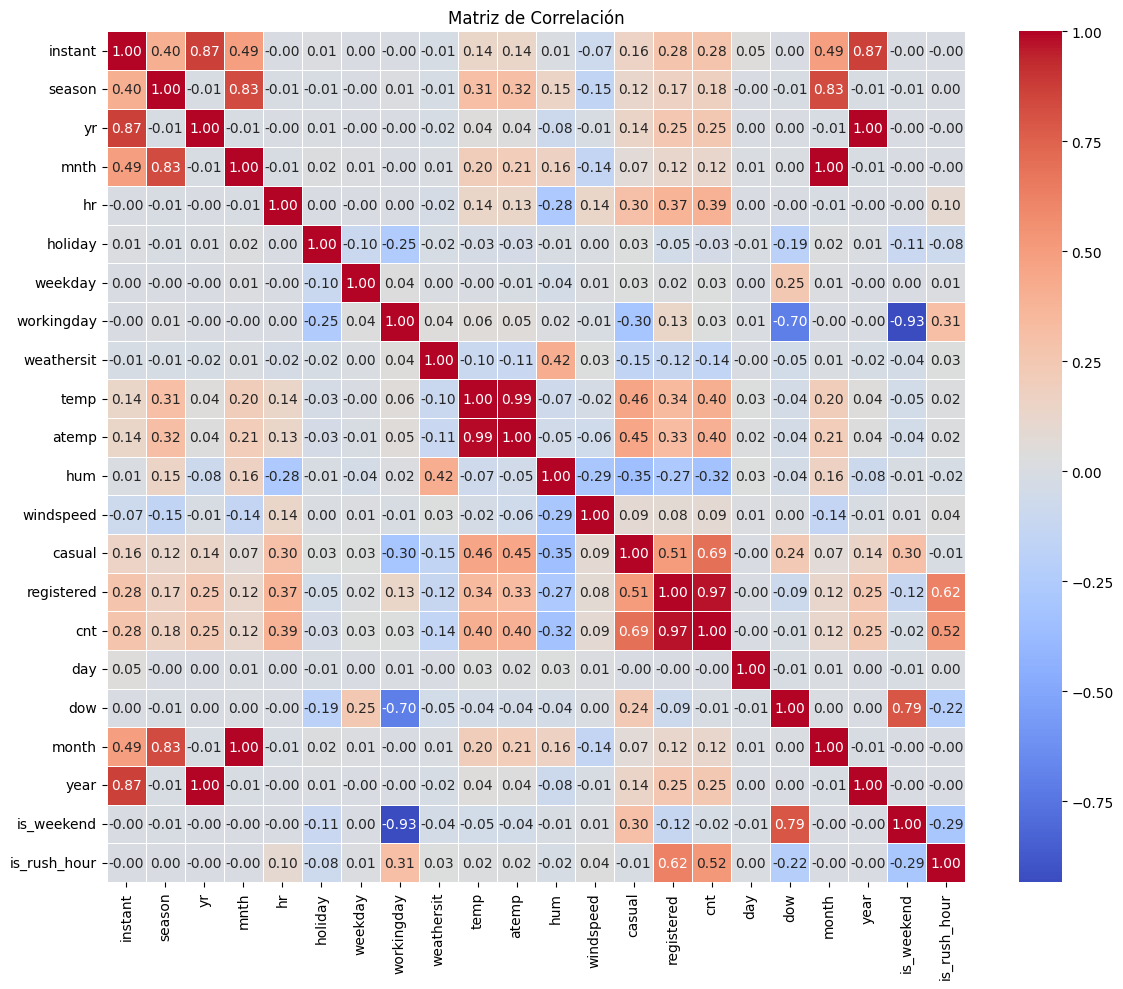

In [92]:
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

### Visualizaciones clave de la demanda

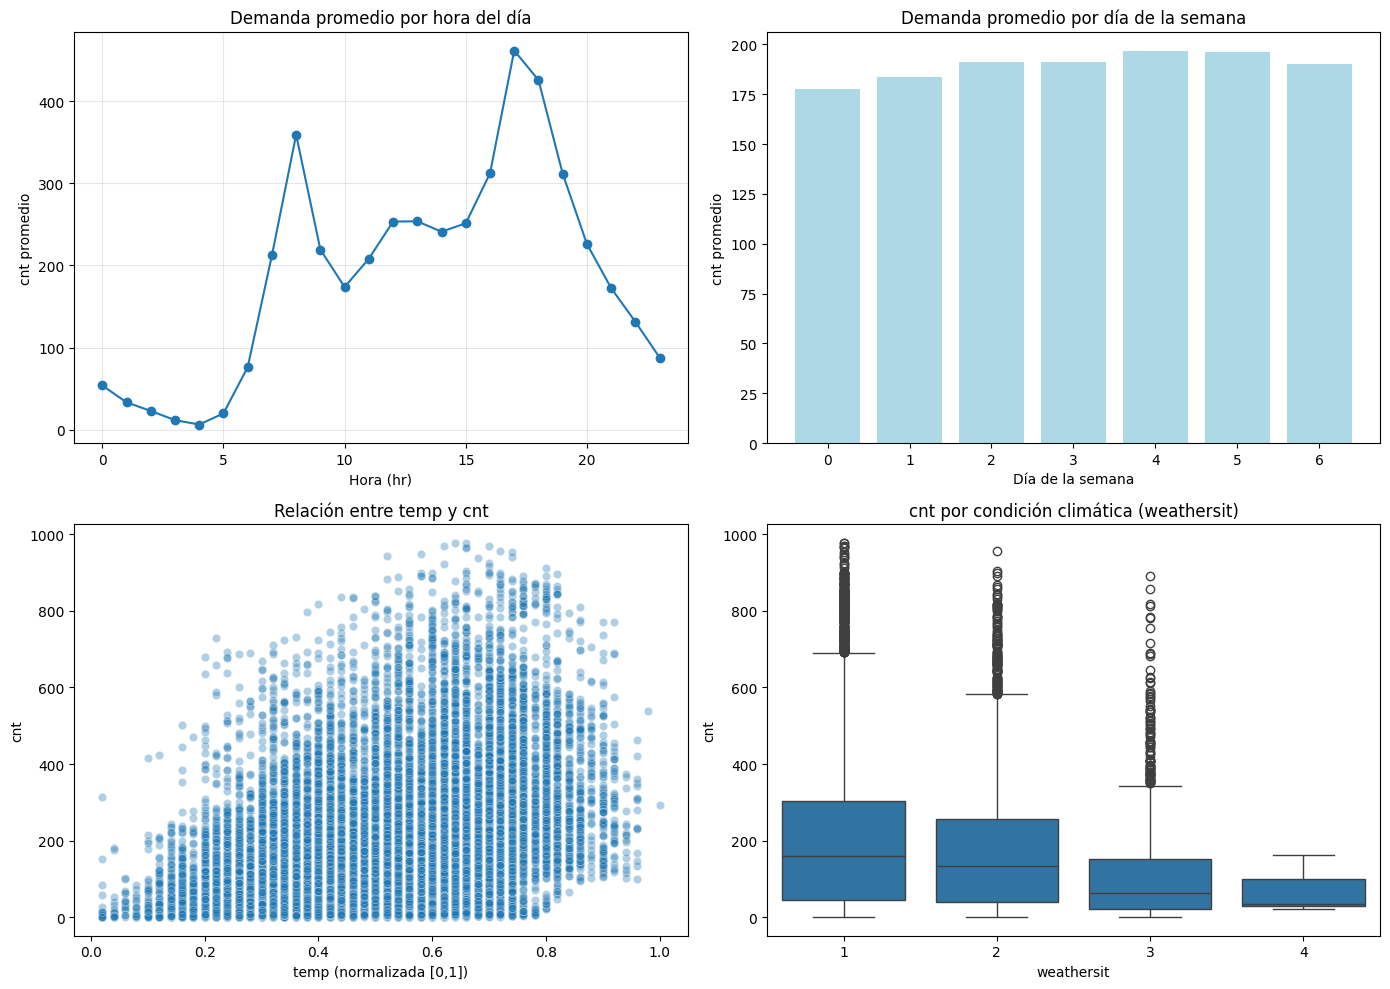

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

hr_mean = df.groupby('hr')['cnt'].mean()
axes[0, 0].plot(hr_mean.index, hr_mean.values, marker='o')
axes[0, 0].set_title('Demanda promedio por hora del día')
axes[0, 0].set_xlabel('Hora (hr)')
axes[0, 0].set_ylabel('cnt promedio')
axes[0, 0].grid(True, alpha=0.3)

dow_mean = df.groupby('weekday')['cnt'].mean() if 'weekday' in df.columns else df.groupby('dow')['cnt'].mean()
axes[0, 1].bar(dow_mean.index.astype(str), dow_mean.values, color='lightblue')
axes[0, 1].set_title('Demanda promedio por día de la semana')
axes[0, 1].set_xlabel('Día de la semana')
axes[0, 1].set_ylabel('cnt promedio')

sns.scatterplot(data=df, x='temp', y='cnt', alpha=0.35, ax=axes[1, 0])
axes[1, 0].set_title('Relación entre temp y cnt')
axes[1, 0].set_xlabel('temp (normalizada [0,1])')
axes[1, 0].set_ylabel('cnt')

sns.boxplot(data=df, x='weathersit', y='cnt', ax=axes[1, 1])
axes[1, 1].set_title('cnt por condición climática (weathersit)')
axes[1, 1].set_xlabel('weathersit')
axes[1, 1].set_ylabel('cnt')

plt.tight_layout()
plt.show()

### Distribución de cnt y log(cnt + 1)

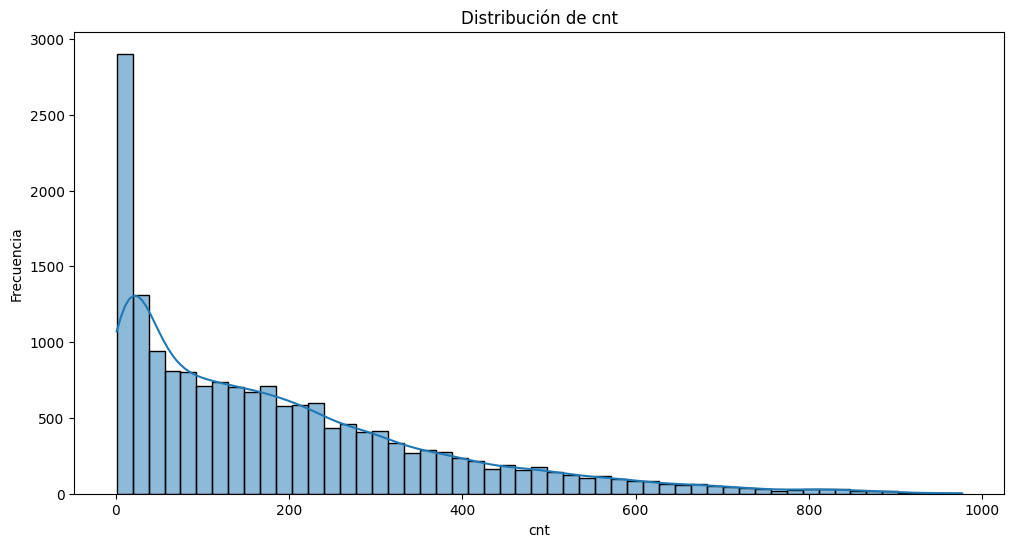

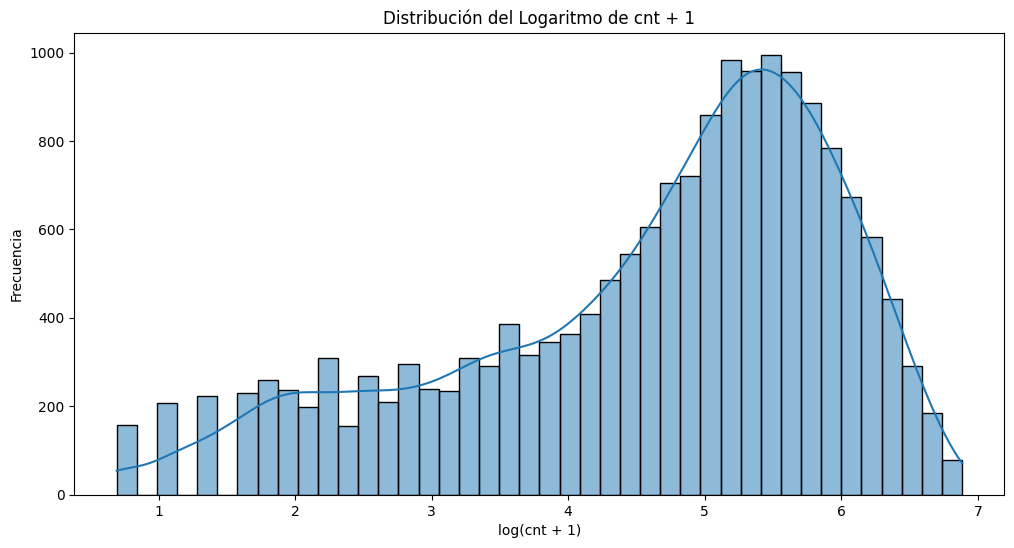

In [94]:
plt.figure(figsize=(12, 6))
sns.histplot(df['cnt'], kde=True)
plt.title('Distribución de cnt')
plt.xlabel('cnt')
plt.ylabel('Frecuencia')
plt.show()

cnt_log = np.log1p(df['cnt'])
plt.figure(figsize=(12, 6))
sns.histplot(cnt_log, kde=True)
plt.title('Distribución del Logaritmo de cnt + 1')
plt.xlabel('log(cnt + 1)')
plt.ylabel('Frecuencia')
plt.show()

## d) Preparación de datos :
- Identificar y documentar valores faltantes o anómalos.
- Aplicar la transformación logarítmica a la variable objetivo. Se recomienda considerar ambos modelos
(modelo base con count y con la versión transformada).
- Normalizar las variables numéricas apropiadamente.


In [95]:
print("Valores nulos por columna:")
na_counts = df.isna().sum()
display(na_counts)

chequeos = []

def add_check(nombre, serie_bool):
    chequeos.append({"chequeo": nombre, "conteo": int(serie_bool.sum())})

if 'cnt' in df.columns:
    add_check("cnt < 0", df['cnt'] < 0)

for col in ['temp', 'atemp', 'hum', 'windspeed']:
    if col in df.columns:
        add_check(f"{col} fuera de [0,1]", (df[col] < 0) | (df[col] > 1))

if 'hr' in df.columns:
    add_check("hr fuera de 0-23", (df['hr'] < 0) | (df['hr'] > 23))
if 'weathersit' in df.columns:
    add_check("weathersit fuera de {1,2,3,4}", ~df['weathersit'].isin([1, 2, 3, 4]))
if 'season' in df.columns:
    add_check("season fuera de {1,2,3,4}", ~df['season'].isin([1, 2, 3, 4]))

chequeos_df = pd.DataFrame(chequeos)
print("\nChequeos de valores anómalos (conteos):")
display(chequeos_df)

Valores nulos por columna:


instant          0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
day              0
dow              0
month            0
year             0
is_weekend       0
hour_category    0
is_rush_hour     0
dtype: int64


Chequeos de valores anómalos (conteos):


,chequeo,conteo
0,cnt < 0,0
1,"temp fuera de [0,1]",0
2,"atemp fuera de [0,1]",0
3,"hum fuera de [0,1]",0
4,"windspeed fuera de [0,1]",0
5,hr fuera de 0-23,0
6,"weathersit fuera de {1,2,3,4}",0
7,"season fuera de {1,2,3,4}",0


In [96]:

df['cnt_log'] = np.log1p(df['cnt'])

print("Distribución de cnt y cnt_log:")
display(df[['cnt', 'cnt_log']].describe())

Distribución de cnt y cnt_log:


,cnt,cnt_log
count,17379.000000,17379.000000
mean,189.463088,4.574739
std,181.387599,1.417869
min,1.000000,0.693147
25%,40.000000,3.713572
50%,142.000000,4.962845
75%,281.000000,5.641907
max,977.000000,6.885510


In [97]:
train_df['cnt_log'] = np.log1p(train_df['cnt'])
val_df['cnt_log'] = np.log1p(val_df['cnt'])
test_df['cnt_log'] = np.log1p(test_df['cnt'])

num_candidates = []
for col in ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'day', 'month', 'year']:
    if col in train_df.columns:
        num_candidates.append(col)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[num_candidates])
val_scaled = scaler.transform(val_df[num_candidates])
test_scaled = scaler.transform(test_df[num_candidates])

X_train_scaled = pd.DataFrame(train_scaled, columns=num_candidates, index=train_df.index)
X_val_scaled = pd.DataFrame(val_scaled, columns=num_candidates, index=val_df.index)
X_test_scaled = pd.DataFrame(test_scaled, columns=num_candidates, index=test_df.index)


y_train_cnt = train_df['cnt'].copy()
y_val_cnt = val_df['cnt'].copy()
y_test_cnt = test_df['cnt'].copy()

y_train_log = train_df['cnt_log']
y_val_log = val_df['cnt_log']
y_test_log = test_df['cnt_log']

print("Columnas escaladas:", num_candidates)
print("Formas:")
print("X_train_scaled:", X_train_scaled.shape, "X_val_scaled:", X_val_scaled.shape, "X_test_scaled:", X_test_scaled.shape)
print("y_train_cnt:", y_train_cnt.shape, "y_train_log:", y_train_log.shape)

Columnas escaladas: ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'day', 'month', 'year']
Formas:
X_train_scaled: (8026, 8) X_val_scaled: (4008, 8) X_test_scaled: (5345, 8)
y_train_cnt: (8026,) y_train_log: (8026,)


## Modelo inicial 
Entrenar un modelo de regresión lineal usando SOLO las variables originales (sin las características
temporales creadas):
- Variables: season, holiday, workingday, weather, temp, atemp, humidity, windspeed
- Evaluar con MSE, RMSE, MAE y R² sobre el conjunto de validación.
- Interpretar los coeficientes más importantes

In [98]:
orig_features = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

df_original = df.loc[:, orig_features + ['cnt']].copy()

x = df_original[orig_features]
y = df_original['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


MSE: 23224.96
R2: 0.27
RMSE: 152.40
MAE: 114.55


- MSE ≈ 23224.96: RMSE es más interpretable porque vuelve a unidades de cnt.
- RMSE ≈ 152.4: el error típico (midiendo más penalización a errores grandes) es ≈152 alquileres.
- MAE ≈ 114.5: en promedio las predicciones se equivocan por ≈114.5 alquileres.
- R² = 0.2666: el modelo lineal explica ~26.7% de la variabilidad de la demanda. Es decir, la mayor parte (≈73%) de la variación en cnt no queda explicada por este modelo con estas variables.

## Modelo mejorado :

Entrenar un segundo modelo incluyendo TODAS las características creadas:

- Comparar métricas con el modelo base sobre el conjunto de validación.
- Crear un gráfico de barras mostrando la importancia de los coeficientes
- Analizar multicolinealidad entre temp y atemp usando VIF (Factor de Inflación de la Varianza)
- Graficar predicciones vs valores reales para ambos modelos


--- Evaluación del Modelo Mejorado (todas las características) ---
MSE (val): 9561.59
RMSE (val): 97.78
MAE (val): 74.34
R² (val): 0.6980

--- Comparación con Modelo Base (solo variables originales) ---
Base  -> MSE: 23224.96 | RMSE: 152.40 | MAE: 114.55 | R²: 0.2666
Mejor -> MSE: 9561.59 | RMSE: 97.78 | MAE: 74.34 | R²: 0.6980

--- Top 10 variables por |coeficiente| ---
                Variable  Coeficiente  Importancia
17          is_rush_hour   250.696357   250.696357
20   hour_category_tarde   189.602738   189.602738
9                  atemp   151.235564   151.235564
8                   temp   110.488608   110.488608
19   hour_category_noche   106.063266   106.063266
10                   hum  -101.643682   101.643682
18  hour_category_mañana    87.638046    87.638046
15                  year    42.780813    42.780813
1                     yr    42.780813    42.780813
6             workingday   -32.174320    32.174320


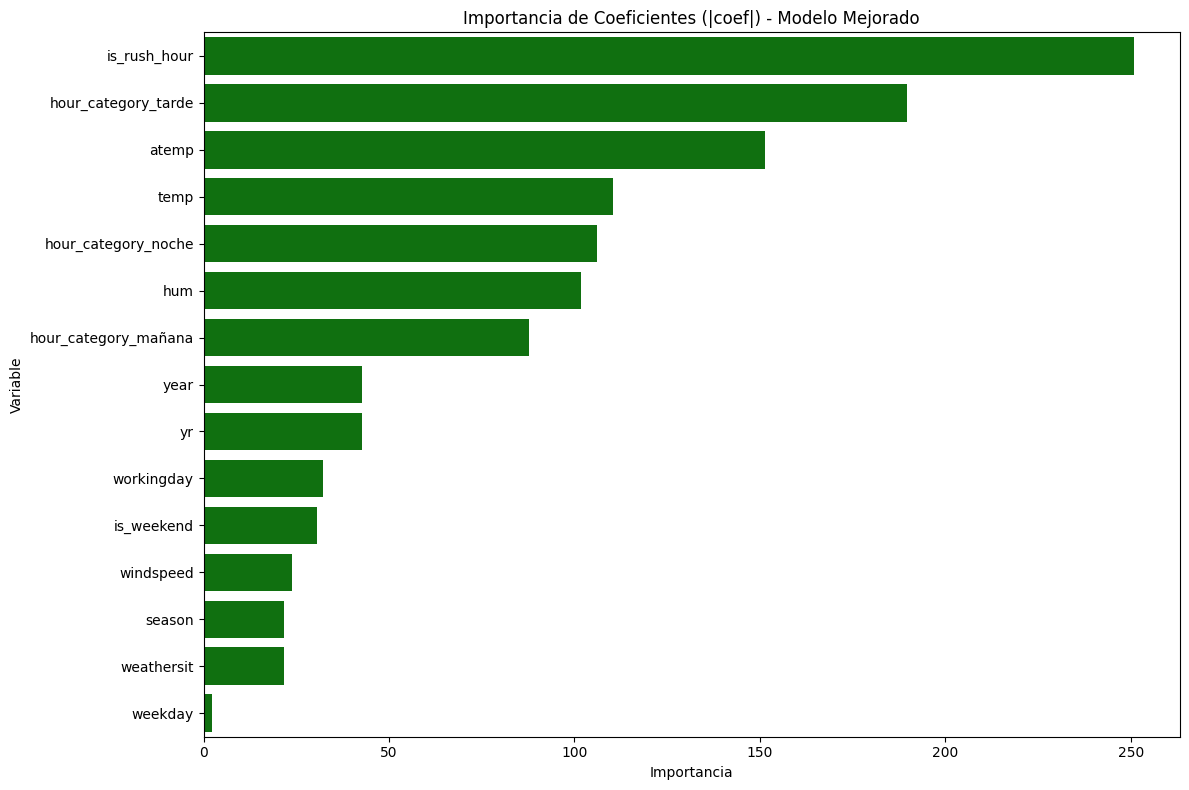


--- VIF (temp y atemp) ---
  Variable        VIF
0     temp  40.810087
1    atemp  40.810087



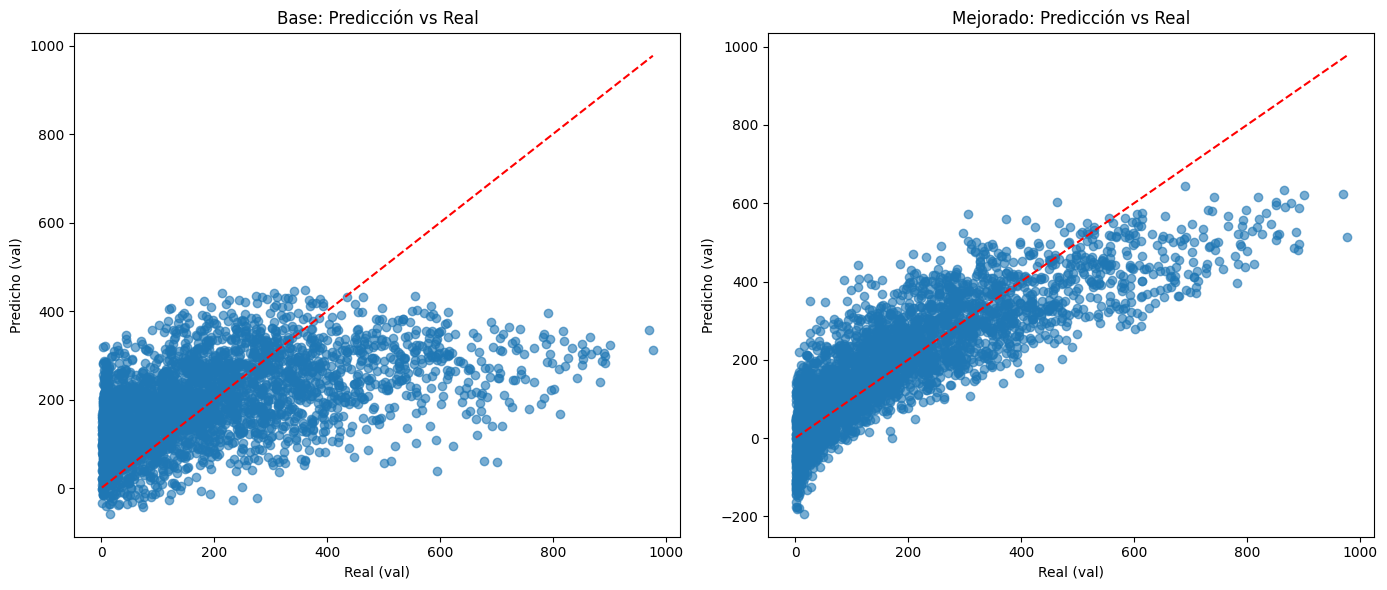

In [99]:
df_improved = df.copy()

encoder = OneHotEncoder(drop='first', sparse_output=False)
cat_features = ['hour_category']
encoded = encoder.fit_transform(df_improved[cat_features])
encoded_cols = encoder.get_feature_names_out(cat_features)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df_improved.index)
df_improved = pd.concat([df_improved.drop(columns=cat_features), encoded_df], axis=1)


X_improved = df_improved.drop(columns=['instant', 'casual', 'registered', 'cnt', 'cnt_log'])
y_cnt = df['cnt']

x_train2, x_test2, y_train2, y_test2 = train_test_split(X_improved, y_cnt, test_size=0.2, random_state=42)

model_improved = LinearRegression()
model_improved.fit(x_train2, y_train2)

y_test_pred2 = model_improved.predict(x_test2)

mse2 = mean_squared_error(y_test2, y_test_pred2)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test2, y_test_pred2)
r2_2 = r2_score(y_test2, y_test_pred2)

print("\n--- Evaluación del Modelo Mejorado (todas las características) ---")
print(f"MSE (val): {mse2:.2f}")
print(f"RMSE (val): {rmse2:.2f}")
print(f"MAE (val): {mae2:.2f}")
print(f"R² (val): {r2_2:.4f}")

_df_base = df.loc[:, orig_features + ['cnt']].copy()
X_base = _df_base[orig_features]
y_base = _df_base['cnt']
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)


print("\n--- Comparación con Modelo Base (solo variables originales) ---")
print(f"Base  -> MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
print(f"Mejor -> MSE: {mse2:.2f} | RMSE: {rmse2:.2f} | MAE: {mae2:.2f} | R²: {r2_2:.4f}")

coef_df = pd.DataFrame({
    'Variable': X_improved.columns,
    'Coeficiente': model_improved.coef_
})
coef_df['Importancia'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values('Importancia', ascending=False)

print("\n--- Top 10 variables por |coeficiente| ---")
print(coef_df.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', data=coef_df.head(15), color='green')
plt.title('Importancia de Coeficientes (|coef|) - Modelo Mejorado')
plt.tight_layout()
plt.show()

# VIF para temp y atemp
x_vif = df[['temp', 'atemp']].dropna()
x_vif_const = sm.add_constant(x_vif)

vifs = []
for i, col in enumerate(x_vif_const.columns):
    if col == 'const':
        continue
    vifs.append({'Variable': col, 'VIF': variance_inflation_factor(x_vif_const.values, i)})

vif_df = pd.DataFrame(vifs)
print("\n--- VIF (temp y atemp) ---")
print(vif_df)
print ("")

plt.figure(figsize=(14, 6))

# Modelo base
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
min_b, max_b = y_test.min(), y_test.max()
plt.plot([min_b, max_b], [min_b, max_b], 'r--')
plt.xlabel('Real (val)')
plt.ylabel('Predicho (val)')
plt.title('Base: Predicción vs Real')

# Modelo mejorado
plt.subplot(1, 2, 2)
plt.scatter(y_test2, y_test_pred2, alpha=0.6)
min_m, max_m = y_test2.min(), y_test2.max()
plt.plot([min_m, max_m], [min_m, max_m], 'r--')
plt.xlabel('Real (val)')
plt.ylabel('Predicho (val)')
plt.title('Mejorado: Predicción vs Real')

plt.tight_layout()
plt.show()

# 3. Regularización: LASSO y Ridge 
## a) Implementación de Ridge:
- Implementar regresión Ridge con un rango de valores alpha entre 10^-3 y 10^3
- Graficar cómo cambian los coeficientes con diferentes valores de alpha
- Reportar el alpha óptimo y las métricas de evaluación sobre el conjunto de validación o el promedio de
validación cruzada.

Valores iniciales de ridge:
MSE: 23228.790093643824
R2: 0.26643018002105434
Alpha optimo: 1
Valores optimizados de ridge:
MSE: 23228.790093643824
R2: 0.26643018002105434


C:\Users\nicon\AppData\Local\Temp\ipykernel_15900\1868588138.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ridge = pd.concat([df_ridge, pd.DataFrame([[i, mse_ridge, r2_ridge]], columns=cols_ridge)], ignore_index=True)


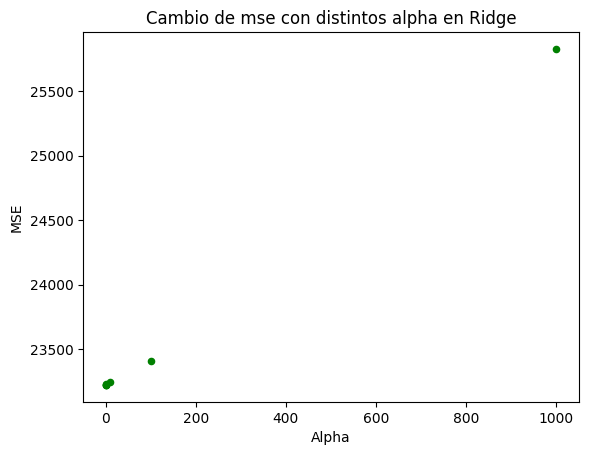

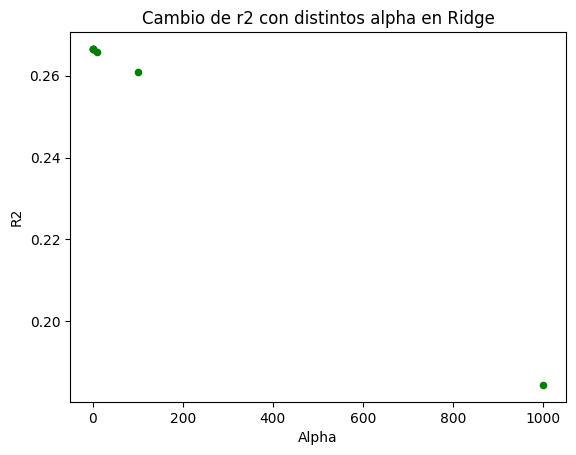

In [100]:
#3.a
l1 = Ridge()
l1.fit(x_train, y_train)
y_pred_l1 = l1.predict(x_test)
print('Valores iniciales de ridge:')
print(f'MSE: {mean_squared_error(y_test, y_pred_l1)}')
print(f'R2: {r2_score(y_test, y_pred_l1)}')

l1_optimizer = GridSearchCV(l1, {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2')
l1_optimizer.fit(x_train, y_train)

print(f'Alpha optimo: {l1_optimizer.best_params_['alpha']}')

l1_opt = Ridge(l1_optimizer.best_params_['alpha'])
l1_opt.fit(x_train, y_train)
y_pred_l1 = l1_opt.predict(x_test)
mse_optimizado_l1 = mean_squared_error(y_test, y_pred_l1)
r2_optimizado_l1 = r2_score(y_test, y_pred_l1)
print('Valores optimizados de ridge:')
print(f'MSE: {mse_optimizado_l1}')
print(f'R2: {r2_optimizado_l1}')

lista_alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cols_ridge = ['alpha', 'mse', 'r2']
df_ridge = pd.DataFrame(columns=cols_ridge)
for i in lista_alpha:
    l1 = Ridge(i)
    l1.fit(x_train, y_train)
    y_pred_l1 = l1.predict(x_test)
    mse_ridge = mean_squared_error(y_test, y_pred_l1)
    r2_ridge = r2_score(y_test, y_pred_l1)
    df_ridge = pd.concat([df_ridge, pd.DataFrame([[i, mse_ridge, r2_ridge]], columns=cols_ridge)], ignore_index=True)
df_ridge

df_ridge.plot(kind='scatter', x='alpha', y='mse', color='green')
plt.title('Cambio de mse con distintos alpha en Ridge')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()
df_ridge.plot(kind='scatter', x='alpha', y='r2', color='green')
plt.title('Cambio de r2 con distintos alpha en Ridge')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.show()

## b) Implementación de LASSO [10 puntos]:
- Implementar regresión LASSO con el mismo rango de valores alpha
- Usar la misma estrategia de validación que para Ridge
- Identificar qué variables son eliminadas por LASSO (coeficientes = 0)
- Comparar el número de características seleccionadas vs Ridge
- Crear una tabla comparativa de métricas entre Lineal, Ridge y LASSO

In [102]:
l2 = Lasso()
l2.fit(x_train, y_train)
y_pred_l2 = l2.predict(x_test)
print('Valores iniciales de lasso:')
print(f'MSE: {mean_squared_error(y_test, y_pred_l2)}')
print(f'R2: {r2_score(y_test, y_pred_l2)}')

l2_optimizer = GridSearchCV(l2, {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2')
l2_optimizer.fit(x_train, y_train)

print(f'Alpha optimo: {l2_optimizer.best_params_['alpha']}')

l2_opt = Ridge(l2_optimizer.best_params_['alpha'])
l2_opt.fit(x_train, y_train)
y_pred_l2 = l2_opt.predict(x_test)
mse_optimizado_l2 = mean_squared_error(y_test, y_pred_l2)
r2_optimizado_l2 = r2_score(y_test, y_pred_l2)
print('Valores optimizados de lasso:')
print(f'MSE: {mse_optimizado_l2}')
print(f'R2: {r2_optimizado_l2}')

ec = ''
for coeficiente, predictor in zip(l2_opt.coef_, x.columns):
    ec += f' {abs(coeficiente):.3f}*{predictor} +'
modelo_ajustado_l2 = f'l2_y_hat = {l2_opt.intercept_:.3f} +{ec}'
modelo_ajustado_l2

table = PrettyTable()
table.field_names = ["Modelo", "MSE", "R2"]
table.add_row(["Sin regulador", mse, r2])
table.add_row(["Ridge", mse_optimizado_l1, r2_optimizado_l1])
table.add_row(["Lasso", mse_optimizado_l2, r2_optimizado_l2])
table

Valores iniciales de lasso:
MSE: 23441.870298150287
R2: 0.2597010647020582
Alpha optimo: 0.01
Valores optimizados de lasso:
MSE: 23225.002607932856
R2: 0.26654978957454234


Modelo,MSE,R2
Sin regulador,23224.95936535196,0.2665511551838641
Ridge,23228.790093643824,0.26643018002105434
Lasso,23225.002607932856,0.26654978957454234


# 4. Elastic Net y Análisis Avanzado 
## a) Elastic Net:
- Implementar Elastic Net optimizando tanto alpha como l1_ratio
- Usar l1_ratio en [0.1, 0.3, 0.5, 0.7, 0.9]
- Documentar los hiperparámetros óptimos encontrados
- Comparar con todos los modelos anteriores sobre el conjunto de validación o el promedio de validación
cruzada.

In [103]:

l3 = ElasticNet()
l3.fit(x_train, y_train)
y_pred_l3 = l3.predict(x_test)
print('Valores iniciales de ElasticNet:')
print(f'MSE: {mean_squared_error(y_test, y_pred_l3)}')
print(f'R2: {r2_score(y_test, y_pred_l3)}')

l3_optimizer_alpha = GridSearchCV(l3, {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2')
l3_optimizer_alpha.fit(x_train, y_train)

l3_optimizer_ratio = GridSearchCV(l3, {'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}, cv=5, scoring='r2')
l3_optimizer_ratio.fit(x_train, y_train)


print(f'Alpha optimo: {l3_optimizer_alpha.best_params_['alpha']}')
print(f'l1_ratio optimo: {l3_optimizer_ratio.best_params_['l1_ratio']}')

l3_opt = ElasticNet(alpha = l3_optimizer_alpha.best_params_['alpha'], l1_ratio = l3_optimizer_ratio.best_params_['l1_ratio'])
l3_opt.fit(x_train, y_train)
y_pred_l3 = l3_opt.predict(x_test)
mse_optimizado_l3 = mean_squared_error(y_test, y_pred_l3)
r2_optimizado_l3 = r2_score(y_test, y_pred_l3)
print('Valores optimizados de ElasticNet:')
print(f'MSE: {mse_optimizado_l3}')
print(f'R2: {r2_optimizado_l3}')

table = PrettyTable()
table.field_names = ["Modelo", "MSE", "R2"]
table.add_row(["Sin regulador", mse, r2])
table.add_row(["Ridge", mse_optimizado_l1, r2_optimizado_l1])
table.add_row(["Lasso", mse_optimizado_l2, r2_optimizado_l2])
table.add_row(["ElasticNet", mse_optimizado_l3, r2_optimizado_l3])
table

Valores iniciales de ElasticNet:
MSE: 29273.3555397749
R2: 0.07554159872629929
Alpha optimo: 0.001
l1_ratio optimo: 0.9
Valores optimizados de ElasticNet:
MSE: 23230.254400063757
R2: 0.26638393693251927


Modelo,MSE,R2
Sin regulador,23224.95936535196,0.2665511551838641
Ridge,23228.790093643824,0.26643018002105434
Lasso,23225.002607932856,0.26654978957454234
ElasticNet,23230.254400063757,0.26638393693251927


## b) Análisis de residuos y patrones temporales [10 puntos]:
- Graficar residuos vs predicciones para detectar heterocedasticidad
- Analizar si hay patrones en los residuos por hora del día o día de la semana
- Crear un gráfico de serie temporal mostrando predicciones vs valores reales para una semana completa
- Realizar test de normalidad de residuos (Shapiro-Wilk o Q-Q plot)

Text(0, 0.5, 'Residuos')

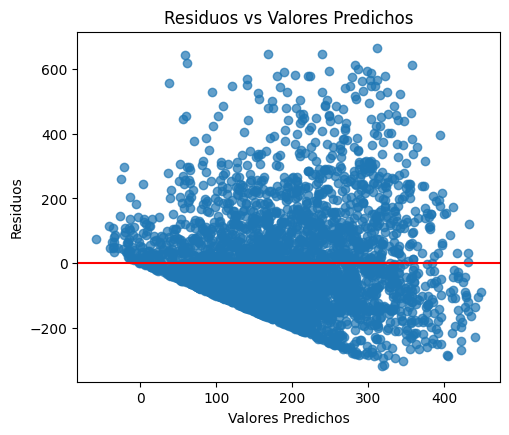

In [104]:
residuos = y_test - y_pred_l3

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 3)
plt.scatter(y_pred_l3, residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores Predichos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

# 5. Conclusiones y Recomendaciones

En esta sección se consolida el desempeño de los modelos, se identifican los factores más influyentes para explicar la demanda y se proponen mejoras y acciones operativas.

In [105]:
table2 = PrettyTable()
table2.field_names = ["Modelo", "MSE", "R2"]
table2.add_row(["Mejorado", mse2, r2_2])
table2.add_row(["Ridge", mse_optimizado_l1, r2_optimizado_l1])
table2.add_row(["Lasso", mse_optimizado_l2, r2_optimizado_l2])
table2.add_row(["ElasticNet", mse_optimizado_l3, r2_optimizado_l3])
table2

Modelo,MSE,R2
Mejorado,9561.589535212088,0.6980430971315466
Ridge,23228.790093643824,0.26643018002105434
Lasso,23225.002607932856,0.26654978957454234
ElasticNet,23230.254400063757,0.26638393693251927


In [106]:

feature_importance_df = None

_coef = np.asarray(model_improved.coef_).ravel()
_features = list(X_improved.columns)
feature_importance_df = pd.DataFrame({
        'Variable': _features,
        'Importancia': np.abs(_coef)
    }).sort_values('Importancia', ascending=False)
fuente = 'Lineal (mejorado)'



top5 = feature_importance_df.head(5).reset_index(drop=True)
print(f"Top 5 factores más importantes: ")
display(top5)

Top 5 factores más importantes: 


,Variable,Importancia
0,is_rush_hour,250.696357
1,hour_category_tarde,189.602738
2,atemp,151.235564
3,temp,110.488608
4,hour_category_noche,106.063266


### Limitaciones del análisis

- Extrapolación temporal: el particionado usa segmentos por día/hora y la validación aleatoria (hold-out o CV) no garantiza estabilidad fuera del período observado; patrones estacionales y eventos futuros pueden cambiar la relación.
- Variables omitidas: no se incluyen eventos especiales (conciertos, feriados locales no marcados), cambios en oferta, interrupciones del servicio o shocks climáticos atípicos.
- Suposiciones de linealidad: los modelos lineales asumen relación lineal y errores homocedásticos; la evidencia de heterocedasticidad y no linealidad sugiere que interacciones y términos no lineales serían útiles. Posible multicolinealidad (p. ej., temp vs atemp) afecta la estabilidad de coeficientes.
- Estacionariedad débil: los procesos temporales (hora-día-mes) introducen autocorrelación que no es modelada explícitamente por OLS.


### Mejoras propuestas (próximos pasos)

1) Validación temporal (time series CV): usar cortes por tiempo (TimeSeriesSplit), entrenamiento en ventanas deslizantes y evaluación por períodos futuros.
2) Modelos no lineales y con interacciones: Random Forest/Gradient Boosting/XGBoost, GAMs o polinomios/interacciones en OLS; explorar splines para temperatura y hora.
3) Modelado explícito del componente temporal: incluir lags (cnt t-1, t-24), medias móviles, codificación cíclica de hora/mes, y/o modelos híbridos con ARIMA/Prophet + regresores exógenos.
4) Enriquecimiento de variables: eventos (conciertos, partidos), calendario (feriados locales), clima granular (precipitación, sensación térmica), oferta (capacidad de estaciones), movilidad urbana.



### Recomendaciones operativas

- Planificación de flota y reubicación: reforzar disponibilidad en horas punta (7–9 y 17–19) y días laborales en zonas de mayor demanda; monitoreo en tiempo real para rebalanceo.
- Políticas dinámicas: ajustar promociones/tarifas en horas valle o condiciones climáticas adversas para suavizar picos y aumentar utilización.
- Gestión por clima: ante altas temperaturas/lluvia, prever menor demanda y reubicar recursos hacia periodos más templados; comunicación proactiva a usuarios.
- Expansión de estaciones: priorizar ubicaciones con alta demanda recurrente por hora/día y conectividad con transporte público.
- Mantenimiento preventivo: programar ventanas de mantenimiento fuera de horas punta, minimizando indisponibilidad.
